# Assignment 1 - Candidate 50507

All imports for this assignment:

In [570]:
# data preprocessing modules
from sklearn import metrics

# ML modules
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Lambda, Activation, Concatenate, Conv1D, Flatten
from keras.optimizers import Adam
from keras.utils import plot_model

# general stuff
import pandas as pd
import io
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

This is performed on my own computer. Not google colab. Limited GPU resources. Images of figures are provided.

## P1 - Permutation-invariant functions

### P1.1 - NN Implementation

In [571]:
df_train = pd.read_csv('./data/train-1.csv')
df_test = pd.read_csv('./data/test-1.csv')

In [572]:
df_train.head()

,4.431320074018723076e-01,5.324051314609411500e-01,4.377698250476299568e-01,6.196628821722993674e-02,7.836767313308944383e-01,9.357891820280233031e-01,9.091042324650751016e-01,6.836156825808235027e-01,8.954095712546213948e-01,8.711219633267553997e-01,7.336462069558589150e-01
0,0.270151,0.563418,0.136042,0.164526,0.013159,0.731077,0.961079,0.202600,0.921334,0.731678,0.416784
1,0.571161,0.124119,0.826382,0.692914,0.817431,0.573339,0.248638,0.632073,0.606688,0.348984,0.590013
2,0.414595,0.541134,0.383968,0.696607,0.113355,0.591044,0.770690,0.016159,0.291561,0.666265,0.477864
3,0.069221,0.047482,0.269938,0.812681,0.533125,0.091919,0.581794,0.854649,0.298028,0.819031,0.415577
4,0.685363,0.227652,0.694577,0.806527,0.368828,0.295510,0.633057,0.680897,0.293867,0.463691,0.548374


In [573]:
print(f'train: {df_train.shape}')
print(f'test: {df_test.shape}')

train: (99999, 11)
test: (9999, 11)


In [574]:
X_train = df_train.drop(df_train.columns[-1], axis=1)
y_train = df_train.drop(df_train.columns[0:10],axis=1)

X_test = df_test.drop(df_test.columns[-1], axis=1)
y_test = df_test.drop(df_test.columns[0:10],axis=1)
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (99999, 10)
y_train: (99999, 1)
X_test: (9999, 10)
y_test: (9999, 1)


In [575]:
# Input shape
n_features = X_train.shape[1:]
n_features

(10,)

In [602]:
# Model 1
lat_dim= 10 # Temporary value for lat_dim variable

def model1(lat_dim):
  network_Φ = Sequential(name='O')
  network_Φ.add(Dense(100, activation='relu', input_shape=n_features))
  network_Φ.add(Dense(lat_dim, activation='softmax'))

  return network_Φ

model1(lat_dim).summary()

Model: "O"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_248 (Dense)           (None, 100)               1100      
                                                                 
 dense_249 (Dense)           (None, 10)                1010      
                                                                 
Total params: 2,110
Trainable params: 2,110
Non-trainable params: 0
_________________________________________________________________


In [603]:
# Model 2
def model2(lat_dim):
  network_ρ = Sequential(name='p')
  network_ρ.add(Lambda(lambda x: tf.reduce_sum(x, axis=1, keepdims=True), input_shape=(lat_dim,))),
  network_ρ.add(Dense(100, activation='relu'))
  network_ρ.add(Dense(1))

  return network_ρ

model2(lat_dim).summary()

Model: "p"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_14 (Lambda)          (None, 1)                 0         
                                                                 
 dense_250 (Dense)           (None, 100)               200       
                                                                 
 dense_251 (Dense)           (None, 1)                 101       
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [608]:
# Combined model
def combined_model(lat_dim):
  combined_model_input = Input(shape=n_features)

  model_Φ_output = model1(lat_dim)(combined_model_input)
  model_ρ_output = model2(lat_dim)(model_Φ_output)

  concat = Concatenate()([model_Φ_output, model_ρ_output])
  combined_model_output = Dense(1)(concat)
  combined_model = keras.Model(inputs=combined_model_input, outputs=combined_model_output)
  return combined_model

In [614]:
combined_model1 = combined_model(lat_dim)
combined_model1.summary()

Model: "model_133"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_195 (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 O (Sequential)                 (None, 10)           2110        ['input_195[0][0]']              
                                                                                                  
 p (Sequential)                 (None, 1)            301         ['O[0][0]']                      
                                                                                                  
 concatenate_30 (Concatenate)   (None, 11)           0           ['O[0][0]',                      
                                                                  'p[0][0]']              

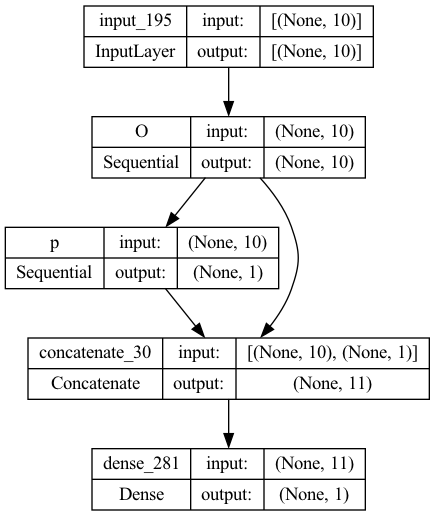

In [615]:
plot_model(combined_model1, 'P11-combined-model.png', show_shapes=True)

Explanation of implementation:
- I first create the two individual models O and p by using the Sequential API. 
- Network_O takes input shape as the input shape of the training data, as in the combined model model O will be structuren "first" in the architecture.
- Network_O has then a Dense layer and an output layer with `lat_dim` dimentions, being passed as a parameter
- Network_p has a first layer that is customized through the `Lambda` layer to apply the sum-decomposition function to the inputs (the outputs of networkO). The function applies a reduction operation to sum the values. This collapsed tensor is then fed as input to network_p
- Lastly, the combined model uses the lower level Functional API to allow for more customization. This model takes `lat_dim`as parameter to descide the input/output shape of the two sub_models. Then, there is a Concatinate layer that concatinates the outputs of the network_O and network_p. This results in a single tensor which is then passed to a last Dense layer that performs linear transformation.

### P1.2

##### lat_dim = 5

In [629]:
lat_dim = 5
val_split = 0.1
n_epochs = 10
batch_size = 128
optimizer = keras.optimizers.SGD(learning_rate=1e-4)

model_l5 = combined_model(lat_dim)
model_l5.compile(optimizer=optimizer, loss='MSE', metrics=['acc'])
history = model_l5.fit(X_train,                          
                y_train,                          
                epochs=n_epochs,                  
                batch_size=batch_size,  
                validation_split=val_split
                )
pred = model_l5.predict(X_test)
score = metrics.mean_squared_error(pred, y_test)
print(f"---------------")
print(f"Final score (MSE) : {score}")


Epoch 1/10


2023-02-24 13:29:16.445121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0767 - acc: 0.0000e+00

2023-02-24 13:29:21.488275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.0767 - acc: 0.0000e+00 - val_loss: 0.0618 - val_acc: 0.0000e+00
Epoch 2/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0519 - acc: 0.0000e+00 - val_loss: 0.0426 - val_acc: 0.0000e+00
Epoch 3/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0366 - acc: 0.0000e+00 - val_loss: 0.0308 - val_acc: 0.0000e+00
Epoch 4/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0272 - acc: 0.0000e+00 - val_loss: 0.0236 - val_acc: 0.0000e+00
Epoch 5/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0215 - acc: 0.0000e+00 - val_loss: 0.0193 - val_acc: 0.0000e+00
Epoch 6/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0181 - acc: 0.0000e+00 - val_loss: 0.0166 - val_acc: 0.0000e+00
Epoch 7/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0160 - acc: 0.0000e+00 - val_loss: 0.0151 - val_acc: 0.0000e+00
Epoch 8/10
704/704 [===========

2023-02-24 13:30:04.707865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
---------------
Final score (MSE) : 0.01352747187656664


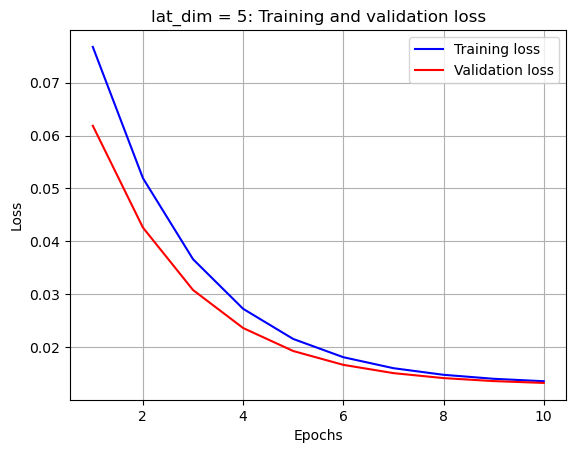

In [630]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('lat_dim = 5: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

##### lat_dim = 100

In [631]:
lat_dim = 100

model_l100 = combined_model(lat_dim)
model_l100.compile(optimizer=optimizer, loss='MSE', metrics=['acc'])
history = model_l100.fit(X_train,                          
                y_train,                          
                epochs=n_epochs,                  
                batch_size=batch_size,  
                validation_split=val_split
                )
pred = model_l100.predict(X_test)
score = metrics.mean_squared_error(pred, y_test)
print(f"---------------")
print(f"Final score (MSE) : {score}")

Epoch 1/10


2023-02-24 13:31:18.996647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2324 - acc: 0.0000e+00

2023-02-24 13:31:24.007925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.2324 - acc: 0.0000e+00 - val_loss: 0.2021 - val_acc: 0.0000e+00
Epoch 2/10
704/704 [==============================] - 5s 7ms/step - loss: 0.1793 - acc: 0.0000e+00 - val_loss: 0.1564 - val_acc: 0.0000e+00
Epoch 3/10
704/704 [==============================] - 5s 7ms/step - loss: 0.1394 - acc: 0.0000e+00 - val_loss: 0.1221 - val_acc: 0.0000e+00
Epoch 4/10
704/704 [==============================] - 5s 7ms/step - loss: 0.1095 - acc: 0.0000e+00 - val_loss: 0.0964 - val_acc: 0.0000e+00
Epoch 5/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0870 - acc: 0.0000e+00 - val_loss: 0.0771 - val_acc: 0.0000e+00
Epoch 6/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0701 - acc: 0.0000e+00 - val_loss: 0.0625 - val_acc: 0.0000e+00
Epoch 7/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0574 - acc: 0.0000e+00 - val_loss: 0.0516 - val_acc: 0.0000e+00
Epoch 8/10
704/704 [===========

2023-02-24 13:32:07.694344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
---------------
Final score (MSE) : 0.033327712238474444


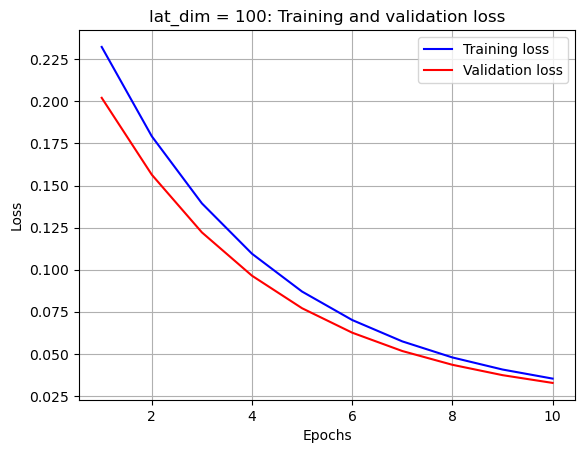

In [632]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('lat_dim = 100: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

Comments:
- Lat_dim = 5 had an MSE of 0.0135 while 100 had 0.0333.
- Even though both models shows to be close to covnergeing by the 10th epoch, lat_dim=5 proves to actually perform better. This seems counterintuitive to me as none of the models overfit the data. One would then presume that the mode complex model (100) would perform better.
- However, the number of epochs seems to slightly too small for both of them to fully converge.

### P1.3

##### lr = 0.1

In [636]:
lat_dim = 100
lr = 0.1

def lrfunction(lr):
  optimizer = keras.optimizers.SGD(learning_rate=lr)

  model_lr01 = combined_model(lat_dim)
  model_lr01.compile(optimizer=optimizer, loss='MSE', metrics=['acc'])
  history = model_lr01.fit(X_train,                          
                  y_train,                          
                  epochs=n_epochs,                  
                  batch_size=batch_size,  
                  validation_split=val_split
                  )
  pred = model_lr01.predict(X_test)
  score = metrics.mean_squared_error(pred, y_test)
  print(f"---------------")
  print(f"Final score (MSE) : {score}")
  
  return history
lrfunction(lr)

Epoch 1/10


2023-02-24 13:38:08.587104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0197 - acc: 0.0000e+00

2023-02-24 13:38:13.481645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 5s 7ms/step - loss: 0.0197 - acc: 0.0000e+00 - val_loss: 0.0189 - val_acc: 0.0000e+00
Epoch 2/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0188 - acc: 0.0000e+00 - val_loss: 0.0187 - val_acc: 0.0000e+00
Epoch 3/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0186 - acc: 0.0000e+00 - val_loss: 0.0189 - val_acc: 0.0000e+00
Epoch 4/10
704/704 [==============================] - 5s 6ms/step - loss: 0.0185 - acc: 0.0000e+00 - val_loss: 0.0183 - val_acc: 0.0000e+00
Epoch 5/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0182 - acc: 0.0000e+00 - val_loss: 0.0180 - val_acc: 0.0000e+00
Epoch 6/10
704/704 [==============================] - 5s 6ms/step - loss: 0.0178 - acc: 0.0000e+00 - val_loss: 0.0174 - val_acc: 0.0000e+00
Epoch 7/10
704/704 [==============================] - 5s 6ms/step - loss: 0.0167 - acc: 0.0000e+00 - val_loss: 0.0147 - val_acc: 0.0000e+00
Epoch 8/10
704/704 [===========

2023-02-24 13:38:55.577021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
---------------
Final score (MSE) : 0.0035883394920842677


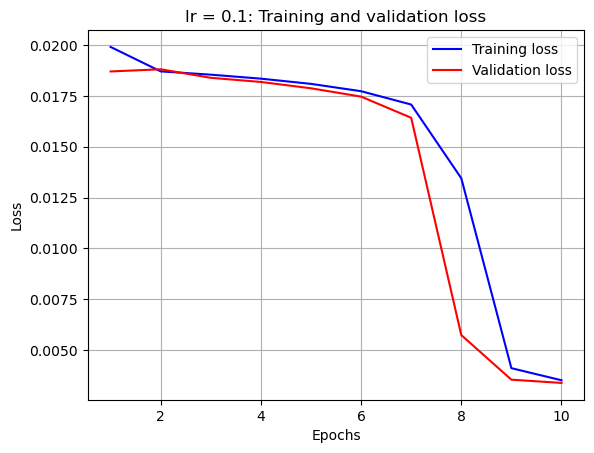

In [637]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('lr = 0.1: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

##### lr = 0.01

In [642]:
lr=0.01
optimizer = keras.optimizers.SGD(learning_rate=lr)

model_lr001 = combined_model(lat_dim)
model_lr001.compile(optimizer=optimizer, loss='MSE', metrics=['acc'])
history = model_lr001.fit(X_train,                          
                y_train,                          
                epochs=n_epochs,                  
                batch_size=batch_size,  
                validation_split=val_split
                )
pred = model_lr001.predict(X_test)
score = metrics.mean_squared_error(pred, y_test)
print(f"---------------")
print(f"Final score (MSE) : {score}")


Epoch 1/10


2023-02-24 13:42:34.657876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0279 - acc: 0.0000e+00

2023-02-24 13:42:39.376212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 5s 7ms/step - loss: 0.0279 - acc: 0.0000e+00 - val_loss: 0.0189 - val_acc: 0.0000e+00
Epoch 2/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0189 - acc: 0.0000e+00 - val_loss: 0.0189 - val_acc: 0.0000e+00
Epoch 3/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0189 - acc: 0.0000e+00 - val_loss: 0.0188 - val_acc: 0.0000e+00
Epoch 4/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0189 - acc: 0.0000e+00 - val_loss: 0.0188 - val_acc: 0.0000e+00
Epoch 5/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0189 - acc: 0.0000e+00 - val_loss: 0.0188 - val_acc: 0.0000e+00
Epoch 6/10
704/704 [==============================] - 5s 6ms/step - loss: 0.0189 - acc: 0.0000e+00 - val_loss: 0.0188 - val_acc: 0.0000e+00
Epoch 7/10
704/704 [==============================] - 4s 6ms/step - loss: 0.0188 - acc: 0.0000e+00 - val_loss: 0.0188 - val_acc: 0.0000e+00
Epoch 8/10
704/704 [===========

2023-02-24 13:43:20.420131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
---------------
Final score (MSE) : 0.01895404896767356


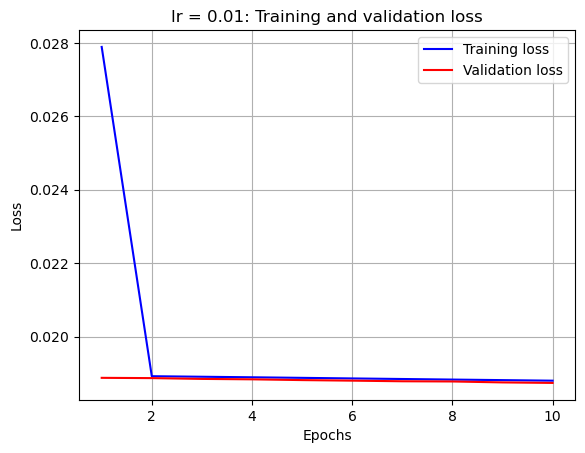

In [643]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('lr = 0.01: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

##### lr = 0.5

In [644]:
lr=0.5
optimizer = keras.optimizers.SGD(learning_rate=lr)

model_lr05 = combined_model(lat_dim)
model_lr05.compile(optimizer=optimizer, loss='MSE', metrics=['acc'])
history = model_lr05.fit(X_train,                          
                y_train,                          
                epochs=n_epochs,                  
                batch_size=batch_size,  
                validation_split=val_split
                )
pred = model_lr05.predict(X_test)
score = metrics.mean_squared_error(pred, y_test)
print(f"---------------")
print(f"Final score (MSE) : {score}")

Epoch 1/10


2023-02-24 13:44:31.388872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0194 - acc: 0.0000e+00

2023-02-24 13:44:36.451840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.0194 - acc: 0.0000e+00 - val_loss: 0.0222 - val_acc: 0.0000e+00
Epoch 2/10
704/704 [==============================] - 5s 6ms/step - loss: 0.0181 - acc: 0.0000e+00 - val_loss: 0.0170 - val_acc: 0.0000e+00
Epoch 3/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0075 - acc: 0.0000e+00 - val_loss: 0.0050 - val_acc: 0.0000e+00
Epoch 4/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0036 - acc: 0.0000e+00 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 5/10
704/704 [==============================] - 5s 6ms/step - loss: 0.0035 - acc: 0.0000e+00 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 6/10
704/704 [==============================] - 5s 6ms/step - loss: 0.0036 - acc: 0.0000e+00 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 7/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0036 - acc: 0.0000e+00 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 8/10
704/704 [===========

2023-02-24 13:45:17.855169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
---------------
Final score (MSE) : 0.0054418611314418835


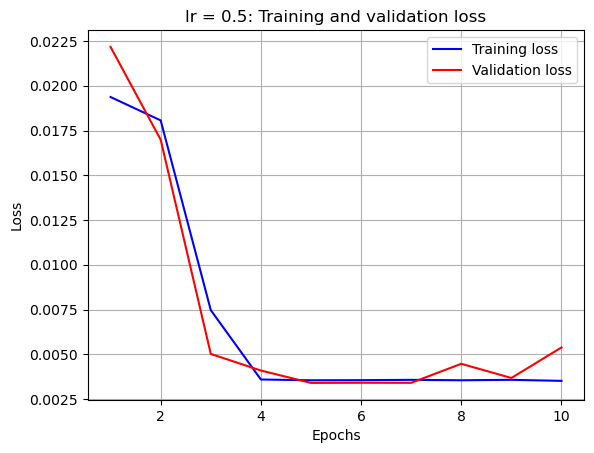

In [645]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('lr = 0.5: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

Comments on results:
- **Lr 0.1**: This shows an "odd" behavious as the loss is higher all the way until epoch 8, indicating that the model struggles to fit and converge. However it seems to converge in the end, with an MSE of 0.0035 (lowest of them all).
- **Lr 0.01**: This model seems to quickly converge at and completes with a respectivly high MSE of 0.0189. This could indicate that the smaller learning rate is not able to keep up and find the complete global optimal. However that seems unlikely, as the initial model in P1.2 did not have such behaviour.
- **Lr 0.5**: This is the most "stochastic" one, which makes sense as it is the highest learning rate. This makes the optimization algorithm "jump" and take large steps, which is not as smooth. You can also see that by the validation loss starting to increase at epoch 10, indicating it is not able to fit the data as well. MSE: 0.0054

### P1.4

Note: Model is already set to ReLu (as in task description). Therefore, we train existing model over 50 epochs first. No learning rate set, so I let be as in task descriptin (1e-4).

In [646]:
lat_dim = 100
n_epochs = 50
optimizer = keras.optimizers.SGD(learning_rate=1e-4)

model_relu = combined_model(lat_dim)
model_relu.compile(optimizer=optimizer, loss='MSE', metrics=['acc'])
history = model_relu.fit(X_train,                          
                y_train,                          
                epochs=n_epochs,                  
                batch_size=batch_size,  
                validation_split=val_split
                )
pred = model_relu.predict(X_test)
score = metrics.mean_squared_error(pred, y_test)
print(f"---------------")
print(f"Final score (MSE) : {score}")

Epoch 1/50


2023-02-24 13:53:14.748036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2405 - acc: 0.0000e+00

2023-02-24 13:53:19.492066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 5s 7ms/step - loss: 0.2405 - acc: 0.0000e+00 - val_loss: 0.2088 - val_acc: 0.0000e+00
Epoch 2/50
704/704 [==============================] - 5s 6ms/step - loss: 0.1849 - acc: 0.0000e+00 - val_loss: 0.1611 - val_acc: 0.0000e+00
Epoch 3/50
704/704 [==============================] - 5s 7ms/step - loss: 0.1433 - acc: 0.0000e+00 - val_loss: 0.1254 - val_acc: 0.0000e+00
Epoch 4/50
704/704 [==============================] - 4s 6ms/step - loss: 0.1122 - acc: 0.0000e+00 - val_loss: 0.0987 - val_acc: 0.0000e+00
Epoch 5/50
704/704 [==============================] - 4s 6ms/step - loss: 0.0889 - acc: 0.0000e+00 - val_loss: 0.0787 - val_acc: 0.0000e+00
Epoch 6/50
704/704 [==============================] - 4s 6ms/step - loss: 0.0715 - acc: 0.0000e+00 - val_loss: 0.0637 - val_acc: 0.0000e+00
Epoch 7/50
704/704 [==============================] - 5s 6ms/step - loss: 0.0584 - acc: 0.0000e+00 - val_loss: 0.0525 - val_acc: 0.0000e+00
Epoch 8/50
704/704 [===========

2023-02-24 13:57:05.654707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step
---------------
Final score (MSE) : 0.019039012969334544


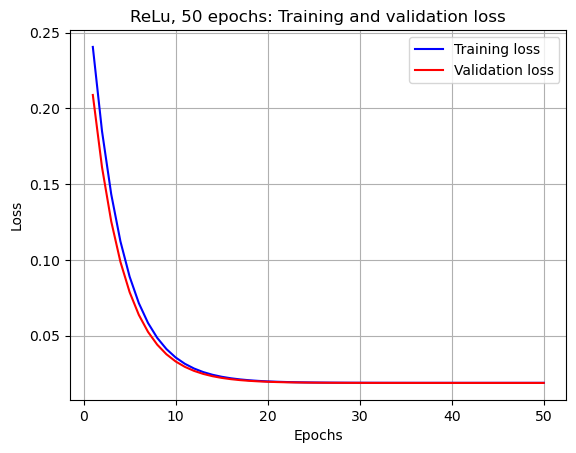

In [647]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('ReLu, 50 epochs: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

In [649]:
#Recreate with Sigmoid:
# Model 1_1
def model1_2(lat_dim):
  network_Φ = Sequential(name='O')
  network_Φ.add(Dense(100, activation='sigmoid', input_shape=n_features))
  network_Φ.add(Dense(lat_dim, activation='sigmoid'))

  return network_Φ

# Model 2_1
def model2_2(lat_dim):
  network_ρ = Sequential(name='p')
  network_ρ.add(Lambda(lambda x: tf.reduce_sum(x, axis=1, keepdims=True), input_shape=(lat_dim,))),
  network_ρ.add(Dense(100, activation='sigmoid'))
  network_ρ.add(Dense(1))

  return network_ρ

# Combined model_2
def combined_model_2(lat_dim):
  combined_model_input = Input(shape=n_features)

  model_Φ_output = model1_2(lat_dim)(combined_model_input)
  model_ρ_output = model2_2(lat_dim)(model_Φ_output)

  concat = Concatenate()([model_Φ_output, model_ρ_output])
  combined_model_output = Dense(1)(concat)
  combined_model_2 = keras.Model(inputs=combined_model_input, outputs=combined_model_output)
  return combined_model_2

combined_model2 = combined_model_2(lat_dim)
combined_model2.summary()

Model: "model_146"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_208 (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 O (Sequential)                 (None, 100)          11200       ['input_208[0][0]']              
                                                                                                  
 p (Sequential)                 (None, 1)            301         ['O[0][0]']                      
                                                                                                  
 concatenate_43 (Concatenate)   (None, 101)          0           ['O[0][0]',                      
                                                                  'p[0][0]']              

In [650]:
model_sigmoid = combined_model_2(lat_dim)
model_sigmoid.compile(optimizer=optimizer, loss='MSE', metrics=['acc'])
history = model_sigmoid.fit(X_train,                          
                y_train,                          
                epochs=n_epochs,                  
                batch_size=batch_size,  
                validation_split=val_split
                )
pred = model_sigmoid.predict(X_test)
score = metrics.mean_squared_error(pred, y_test)
print(f"---------------")
print(f"Final score (MSE) : {score}")

Epoch 1/50


2023-02-24 14:02:43.717446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0351 - acc: 0.0000e+00

2023-02-24 14:02:48.523242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 5s 7ms/step - loss: 0.0351 - acc: 0.0000e+00 - val_loss: 0.0185 - val_acc: 0.0000e+00
Epoch 2/50
704/704 [==============================] - 5s 6ms/step - loss: 0.0186 - acc: 0.0000e+00 - val_loss: 0.0185 - val_acc: 0.0000e+00
Epoch 3/50
704/704 [==============================] - 5s 6ms/step - loss: 0.0186 - acc: 0.0000e+00 - val_loss: 0.0185 - val_acc: 0.0000e+00
Epoch 4/50
704/704 [==============================] - 5s 7ms/step - loss: 0.0186 - acc: 0.0000e+00 - val_loss: 0.0185 - val_acc: 0.0000e+00
Epoch 5/50
704/704 [==============================] - 4s 6ms/step - loss: 0.0185 - acc: 0.0000e+00 - val_loss: 0.0185 - val_acc: 0.0000e+00
Epoch 6/50
704/704 [==============================] - 5s 6ms/step - loss: 0.0185 - acc: 0.0000e+00 - val_loss: 0.0185 - val_acc: 0.0000e+00
Epoch 7/50
704/704 [==============================] - 4s 6ms/step - loss: 0.0185 - acc: 0.0000e+00 - val_loss: 0.0185 - val_acc: 0.0000e+00
Epoch 8/50
704/704 [===========

2023-02-24 14:06:29.627266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
---------------
Final score (MSE) : 0.018399018631248067


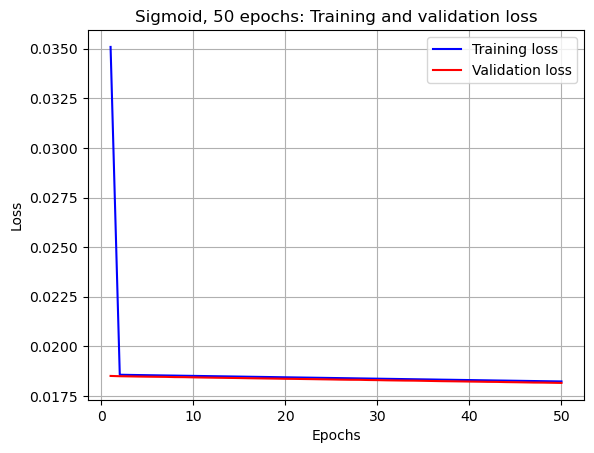

In [652]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Sigmoid, 50 epochs: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

Comments on ReLu vs Sigmoid
- This task shows some interesting results and the effects that different activation functions has on the model.
- **ReLu**: The relu activation function is commonly used of regression problems where the goal is to have a continuous value. It can be used to ensure that outputs are always positive and it does not have an upper bound, unlike sigmoid. This can be reflected in the relative "smooth" training graph my the ReLu implementation. It converges nicely and quite quick, so there seems to not be necessary with all 50 epochs. MSE: 0.01903.
- **Sigmoid**: Commonly used in binary classification where you want to have a binary outcome (0/1). This is obvious in the visual representation as well, with the "non-smoothness". However, the way that it has absolutely no fluctuations seems suspicious and can possibly be influenced by this being run on my local machine. Anyways, the binary nature of sigmoid is cleary visible. MSE: 0.01839.

### P1.5

In [670]:
lat_dim_range = list(range(1, 11)) + list(range(20, 101, 10)) #range of lat_dim

-----------------------------

Training models for lat_dim = : 1 
-----------------------------

Epoch 1/2


2023-02-24 15:16:56.660519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0806 - acc: 0.0000e+00

2023-02-24 15:17:02.094228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.0806 - acc: 0.0000e+00 - val_loss: 0.0477 - val_acc: 0.0000e+00
Epoch 2/2
 50/313 [===>..........................] - ETA: 0s

2023-02-24 15:17:07.054745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.026740473481691
Epoch 1/2


2023-02-24 15:17:08.107057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2853 - acc: 0.0000e+00

2023-02-24 15:17:12.884081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.2853 - acc: 0.0000e+00 - val_loss: 0.2086 - val_acc: 0.0000e+00
Epoch 2/2
 50/313 [===>..........................] - ETA: 0s

2023-02-24 15:17:17.895912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.11648152957364262
-----------------------------

Training models for lat_dim = : 2 
-----------------------------

Epoch 1/2


2023-02-24 15:17:18.907291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0275 - acc: 0.0000e+00

2023-02-24 15:17:23.847992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.0275 - acc: 0.0000e+00 - val_loss: 0.0209 - val_acc: 0.0000e+00
Epoch 2/2
 49/313 [===>..........................] - ETA: 0s

2023-02-24 15:17:29.046527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.01796143416370203
Epoch 1/2


2023-02-24 15:17:30.065936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2703 - acc: 0.0000e+00

2023-02-24 15:17:34.880329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 5s 7ms/step - loss: 0.2703 - acc: 0.0000e+00 - val_loss: 0.0893 - val_acc: 0.0000e+00
Epoch 2/2
 48/313 [===>..........................] - ETA: 0s

2023-02-24 15:17:39.965220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.02945908403525225
-----------------------------

Training models for lat_dim = : 3 
-----------------------------

Epoch 1/2


2023-02-24 15:17:40.973255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.3931 - acc: 0.0000e+00

2023-02-24 15:17:46.045022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.3931 - acc: 0.0000e+00 - val_loss: 0.2731 - val_acc: 0.0000e+00
Epoch 2/2
 22/313 [=>............................] - ETA: 0s 

2023-02-24 15:17:51.475873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step
--- Score (MSE) : 0.14156193414903498
Epoch 1/2


2023-02-24 15:17:52.636362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0162 - acc: 0.0000e+00

2023-02-24 15:17:57.711468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.0162 - acc: 0.0000e+00 - val_loss: 0.0159 - val_acc: 0.0000e+00
Epoch 2/2
 45/313 [===>..........................] - ETA: 0s

2023-02-24 15:18:03.039387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.01572531982858676
-----------------------------

Training models for lat_dim = : 4 
-----------------------------

Epoch 1/2


2023-02-24 15:18:06.526164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2113 - acc: 0.0000e+00

2023-02-24 15:18:12.133844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.2113 - acc: 0.0000e+00 - val_loss: 0.1566 - val_acc: 0.0000e+00
Epoch 2/2
 42/313 [===>..........................] - ETA: 0s

2023-02-24 15:18:17.579431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.09070313401338882
Epoch 1/2


2023-02-24 15:18:18.626562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.3967 - acc: 0.0000e+00

2023-02-24 15:18:23.680023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.3967 - acc: 0.0000e+00 - val_loss: 0.2817 - val_acc: 0.0000e+00
Epoch 2/2
 43/313 [===>..........................] - ETA: 0s

2023-02-24 15:18:28.997707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.14746675726559563
-----------------------------

Training models for lat_dim = : 5 
-----------------------------

Epoch 1/2


2023-02-24 15:18:30.013423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0207 - acc: 0.0000e+00

2023-02-24 15:18:34.989552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.0207 - acc: 0.0000e+00 - val_loss: 0.0195 - val_acc: 0.0000e+00
Epoch 2/2
 35/313 [==>...........................] - ETA: 0s

2023-02-24 15:18:40.338240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.0185113020562659
Epoch 1/2


2023-02-24 15:18:41.382104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0923 - acc: 0.0000e+00

2023-02-24 15:18:46.300000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.0923 - acc: 0.0000e+00 - val_loss: 0.0730 - val_acc: 0.0000e+00
Epoch 2/2
 44/313 [===>..........................] - ETA: 0s

2023-02-24 15:18:51.391363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.05085443311883128
-----------------------------

Training models for lat_dim = : 6 
-----------------------------

Epoch 1/2


2023-02-24 15:18:52.418693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0738 - acc: 0.0000e+00

2023-02-24 15:18:57.513065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.0738 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 2/2
 41/313 [==>...........................] - ETA: 0s

2023-02-24 15:19:02.656785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.03604033661770762
Epoch 1/2


2023-02-24 15:19:03.694832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.6062 - acc: 0.0000e+00

2023-02-24 15:19:08.552094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.6062 - acc: 0.0000e+00 - val_loss: 0.4498 - val_acc: 0.0000e+00
Epoch 2/2
 43/313 [===>..........................] - ETA: 0s

2023-02-24 15:19:13.850563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.25176380380501096
-----------------------------

Training models for lat_dim = : 7 
-----------------------------

Epoch 1/2


2023-02-24 15:19:14.942997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0899 - acc: 0.0000e+00

2023-02-24 15:19:19.852023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.0899 - acc: 0.0000e+00 - val_loss: 0.0672 - val_acc: 0.0000e+00
Epoch 2/2
 48/313 [===>..........................] - ETA: 0s

2023-02-24 15:19:24.952293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.04280519752160199
Epoch 1/2


2023-02-24 15:19:25.965744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.3607 - acc: 0.0000e+00

2023-02-24 15:19:30.842404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.3607 - acc: 0.0000e+00 - val_loss: 0.2538 - val_acc: 0.0000e+00
Epoch 2/2
 41/313 [==>...........................] - ETA: 0s

2023-02-24 15:19:35.847079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.13552925317120604
-----------------------------

Training models for lat_dim = : 8 
-----------------------------

Epoch 1/2


2023-02-24 15:19:36.876955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.4563 - acc: 0.0000e+00

2023-02-24 15:19:42.028848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.4563 - acc: 0.0000e+00 - val_loss: 0.2920 - val_acc: 0.0000e+00
Epoch 2/2
 38/313 [==>...........................] - ETA: 0s

2023-02-24 15:19:47.311854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.12914741137810412
Epoch 1/2


2023-02-24 15:19:48.386581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0514 - acc: 0.0000e+00

2023-02-24 15:19:53.220175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.0514 - acc: 0.0000e+00 - val_loss: 0.0449 - val_acc: 0.0000e+00
Epoch 2/2
 43/313 [===>..........................] - ETA: 0s

2023-02-24 15:19:58.365164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.03690560260813842
-----------------------------

Training models for lat_dim = : 9 
-----------------------------

Epoch 1/2


2023-02-24 15:19:59.492988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2108 - acc: 0.0000e+00

2023-02-24 15:20:04.496615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.2108 - acc: 0.0000e+00 - val_loss: 0.1684 - val_acc: 0.0000e+00
Epoch 2/2
 42/313 [===>..........................] - ETA: 0s

2023-02-24 15:20:09.558778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.11386229297412509
Epoch 1/2


2023-02-24 15:20:10.662645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2624 - acc: 0.0000e+00

2023-02-24 15:20:15.895787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.2624 - acc: 0.0000e+00 - val_loss: 0.2207 - val_acc: 0.0000e+00
Epoch 2/2
 45/313 [===>..........................] - ETA: 0s

2023-02-24 15:20:21.157614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.1613422579758565
-----------------------------

Training models for lat_dim = : 10 
-----------------------------

Epoch 1/2


2023-02-24 15:20:22.306435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.1718 - acc: 0.0000e+00

2023-02-24 15:20:27.950006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.1718 - acc: 0.0000e+00 - val_loss: 0.1449 - val_acc: 0.0000e+00
Epoch 2/2
 43/313 [===>..........................] - ETA: 0s

2023-02-24 15:20:33.410513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step
--- Score (MSE) : 0.10783183539759421
Epoch 1/2


2023-02-24 15:20:34.671116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2445 - acc: 0.0000e+00

2023-02-24 15:20:39.685403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.2445 - acc: 0.0000e+00 - val_loss: 0.1861 - val_acc: 0.0000e+00
Epoch 2/2
 22/313 [=>............................] - ETA: 1s

2023-02-24 15:20:45.142957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step
--- Score (MSE) : 0.11669803050735163
-----------------------------

Training models for lat_dim = : 20 
-----------------------------

Epoch 1/2


2023-02-24 15:20:46.410478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.3026 - acc: 0.0000e+00

2023-02-24 15:20:51.311062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.3026 - acc: 0.0000e+00 - val_loss: 0.2514 - val_acc: 0.0000e+00
Epoch 2/2
 46/313 [===>..........................] - ETA: 0s

2023-02-24 15:20:56.431114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.17743457744419505
Epoch 1/2


2023-02-24 15:20:57.470417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.1751 - acc: 0.0000e+00

2023-02-24 15:21:02.626541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.1751 - acc: 0.0000e+00 - val_loss: 0.1487 - val_acc: 0.0000e+00
Epoch 2/2
 41/313 [==>...........................] - ETA: 0s

2023-02-24 15:21:07.774653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.11116026874496074
-----------------------------

Training models for lat_dim = : 30 
-----------------------------

Epoch 1/2


2023-02-24 15:21:08.831972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.1829 - acc: 0.0000e+00

2023-02-24 15:21:14.200414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.1829 - acc: 0.0000e+00 - val_loss: 0.1528 - val_acc: 0.0000e+00
Epoch 2/2
 46/313 [===>..........................] - ETA: 0s

2023-02-24 15:21:19.295321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step
--- Score (MSE) : 0.1106644622602022
Epoch 1/2


2023-02-24 15:21:20.437447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2272 - acc: 0.0000e+00

2023-02-24 15:21:25.421441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.2272 - acc: 0.0000e+00 - val_loss: 0.1967 - val_acc: 0.0000e+00
Epoch 2/2
 50/313 [===>..........................] - ETA: 0s

2023-02-24 15:21:30.488573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.15268637257489956
-----------------------------

Training models for lat_dim = : 40 
-----------------------------

Epoch 1/2


2023-02-24 15:21:31.547721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2696 - acc: 0.0000e+00

2023-02-24 15:21:36.283691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 5s 7ms/step - loss: 0.2696 - acc: 0.0000e+00 - val_loss: 0.2279 - val_acc: 0.0000e+00
Epoch 2/2
 40/313 [==>...........................] - ETA: 0s

2023-02-24 15:21:41.294380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.16855737459903777
Epoch 1/2


2023-02-24 15:21:42.335498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2086 - acc: 0.0000e+00

2023-02-24 15:21:47.445087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.2086 - acc: 0.0000e+00 - val_loss: 0.1712 - val_acc: 0.0000e+00
Epoch 2/2
 41/313 [==>...........................] - ETA: 0s

2023-02-24 15:21:52.721415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.12012974639323885
-----------------------------

Training models for lat_dim = : 50 
-----------------------------

Epoch 1/2


2023-02-24 15:21:53.756918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.1972 - acc: 0.0000e+00

2023-02-24 15:21:58.730412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.1972 - acc: 0.0000e+00 - val_loss: 0.1707 - val_acc: 0.0000e+00
Epoch 2/2
 37/313 [==>...........................] - ETA: 0s

2023-02-24 15:22:03.813254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step
--- Score (MSE) : 0.132376651275861
Epoch 1/2


2023-02-24 15:22:05.021187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2093 - acc: 0.0000e+00

2023-02-24 15:22:09.906912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.2093 - acc: 0.0000e+00 - val_loss: 0.1817 - val_acc: 0.0000e+00
Epoch 2/2
 40/313 [==>...........................] - ETA: 0s

2023-02-24 15:22:14.850144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.1417294792313057
-----------------------------

Training models for lat_dim = : 60 
-----------------------------

Epoch 1/2


2023-02-24 15:22:15.896877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2240 - acc: 0.0000e+00

2023-02-24 15:22:20.583295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 5s 7ms/step - loss: 0.2240 - acc: 0.0000e+00 - val_loss: 0.1925 - val_acc: 0.0000e+00
Epoch 2/2
 50/313 [===>..........................] - ETA: 0s

2023-02-24 15:22:25.635910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.1477111782722429
Epoch 1/2


2023-02-24 15:22:26.669391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2192 - acc: 0.0000e+00

2023-02-24 15:22:31.579004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.2192 - acc: 0.0000e+00 - val_loss: 0.1903 - val_acc: 0.0000e+00
Epoch 2/2
 48/313 [===>..........................] - ETA: 0s

2023-02-24 15:22:36.555155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.14831121020279098
-----------------------------

Training models for lat_dim = : 70 
-----------------------------

Epoch 1/2


2023-02-24 15:22:37.576914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2366 - acc: 0.0000e+00

2023-02-24 15:22:42.558457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.2366 - acc: 0.0000e+00 - val_loss: 0.2005 - val_acc: 0.0000e+00
Epoch 2/2
 23/313 [=>............................] - ETA: 0s 

2023-02-24 15:22:47.625566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.14934313651194966
Epoch 1/2


2023-02-24 15:22:48.672141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2107 - acc: 0.0000e+00

2023-02-24 15:22:53.699118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.2107 - acc: 0.0000e+00 - val_loss: 0.1797 - val_acc: 0.0000e+00
Epoch 2/2
 23/313 [=>............................] - ETA: 0s 

2023-02-24 15:22:59.237442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.1349702475019354
-----------------------------

Training models for lat_dim = : 80 
-----------------------------

Epoch 1/2


2023-02-24 15:23:00.295912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2532 - acc: 0.0000e+00

2023-02-24 15:23:05.326713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.2532 - acc: 0.0000e+00 - val_loss: 0.2182 - val_acc: 0.0000e+00
Epoch 2/2
 29/313 [=>............................] - ETA: 1s

2023-02-24 15:23:10.573135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step
--- Score (MSE) : 0.16750677682602585
Epoch 1/2


2023-02-24 15:23:11.774409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.1621 - acc: 0.0000e+00

2023-02-24 15:23:16.770977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.1621 - acc: 0.0000e+00 - val_loss: 0.1348 - val_acc: 0.0000e+00
Epoch 2/2
 49/313 [===>..........................] - ETA: 0s

2023-02-24 15:23:22.079695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.09695008209293617
-----------------------------

Training models for lat_dim = : 90 
-----------------------------

Epoch 1/2


2023-02-24 15:23:23.172005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2445 - acc: 0.0000e+00

2023-02-24 15:23:27.974537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 7ms/step - loss: 0.2445 - acc: 0.0000e+00 - val_loss: 0.2123 - val_acc: 0.0000e+00
Epoch 2/2
 19/313 [>.............................] - ETA: 1s

2023-02-24 15:23:32.975192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.1652407638443493
Epoch 1/2


2023-02-24 15:23:34.048598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2532 - acc: 0.0000e+00

2023-02-24 15:23:39.283347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.2532 - acc: 0.0000e+00 - val_loss: 0.2196 - val_acc: 0.0000e+00
Epoch 2/2
 20/313 [>.............................] - ETA: 0s 

2023-02-24 15:23:45.086534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step
--- Score (MSE) : 0.17017445654713295
-----------------------------

Training models for lat_dim = : 100 
-----------------------------

Epoch 1/2


2023-02-24 15:23:51.034151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2664 - acc: 0.0000e+00

2023-02-24 15:23:57.530986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 12s 9ms/step - loss: 0.2664 - acc: 0.0000e+00 - val_loss: 0.2266 - val_acc: 0.0000e+00
Epoch 2/2
 17/313 [>.............................] - ETA: 0s 

2023-02-24 15:24:03.590119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.1705516806205123
Epoch 1/2


2023-02-24 15:24:04.750865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.2357 - acc: 0.0000e+00

2023-02-24 15:24:09.925842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 6s 8ms/step - loss: 0.2357 - acc: 0.0000e+00 - val_loss: 0.2039 - val_acc: 0.0000e+00
Epoch 2/2
 44/313 [===>..........................] - ETA: 0s

2023-02-24 15:24:15.081865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
--- Score (MSE) : 0.15738357780050774


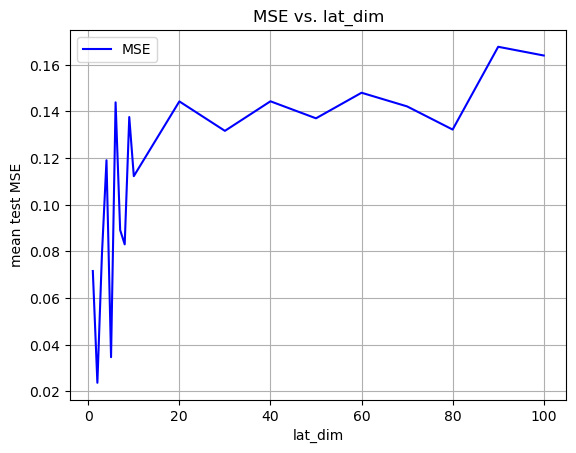

In [674]:
# Loop over the values of lat_dim and run the training experiment
# Chooses combined_model(), which is then ReLu, as defined in task description

n_epochs = 2
batch_size = 128
test_mse_values = []

for lat_dim in lat_dim_range:
    print("-----------------------------\n")
    print("Training models for lat_dim = : %s " % (int(lat_dim)))
    print("-----------------------------\n")
    mse_values = []
    for i in range(2):
        model_total = combined_model(lat_dim)
        model_total.compile(optimizer=optimizer, loss='MSE', metrics=['acc'])
        history = model_total.fit(X_train,                          
                      y_train,                          
                      epochs=n_epochs,                  
                      batch_size=batch_size,  
                      validation_split=val_split
                      )
        best_epoch = np.argmin(history.history['val_loss']) # returns the indices of the minimum values
        # mse = np.mean((y_test - pred)**2) # calculates mean
        pred = model_total.predict(X_test)
        mse = metrics.mean_squared_error(pred, y_test)
        mse_values.append(mse) # pushes values to save before calculation
        print(f"--- Score (MSE) : {mse}")

    avg_mse = np.mean(mse_values, axis=0)
    test_mse_values.append(avg_mse)

# Plotting MSE and lat_dim
plt.plot(lat_dim_range, test_mse_values, 'b',label='MSE')
plt.title('MSE vs. lat_dim')
plt.xlabel('lat_dim')
plt.ylabel('mean test MSE')
plt.legend()
plt.grid()
plt.show()


Comments:
- This grash displays a somewhat arbrirary relationship between test MSE and lat_dim. The higher the value of lat_dim, the higher the mean test MSE. However, given the large fluctuations in the values from epoch to epoch, the model seems not to be able to fit the training data well enough. This result indicates that a different neural network architechture, possibly with more layers than stated in the tast requirement, or further tuning of hyperparameters would be necessary to get a more convincing relationship between the dimentions and the MSE.